<a href="https://colab.research.google.com/github/nanochiplab/Yapay_Sinir_Aglari/blob/main/Face_Mask_Detection_Kaggle_Final_MobileNet_Adam_128x128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1.Gerekli Kütüphaneleri Yüklüyoruz
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D # Added GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split



In [ ]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas as pd
od.download("https://www.kaggle.com/datasets/omkargurav/face-mask-dataset")

# SAYIN GÖKALP HOCAM BU KUL. ADINI VE ŞİFREYİ KULLANINIZ..
# username:"picosoft"
# key:"f5be8962e8a1250ea639b012ed1ecfd6"


data_dir = '/content/face-mask-dataset/data'
os.chdir(data_dir)

In [ ]:
images = []
labels = []

# Tüm görüntüler için hedef boyutları belirliyoruz...
target_size = (224, 224)  # Örnek boyutlandırma

for folder_name in os.listdir(data_dir):
    # Skip if it's not a directory (like model weight files)
    if not os.path.isdir(os.path.join(data_dir, folder_name)):
        continue

    label = folder_name                 # Altdizinlere göre etiketleme yapacağız..
    folder_path = os.path.join(data_dir, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)

            # Read and resize the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, target_size)  # target_size'a göre tekrar boyutlandırma

            images.append(image)
            labels.append(label)

images = np.array(images) # np dizisine çeviriyoruz...
labels = np.array(labels) # np dizisine çeviriyoruz...

print('Dosyalar başarıyla yüklendi......')


Dosyalar başarıyla yüklendi......


In [ ]:
# 3.	Önceden Eğitilmiş (Pre-trained) Modellerin Hazırlanması

# Sınıflandırıcı olarak MobileNetV1'ı (pre-trained) kullanacağız....

from tensorflow.keras.applications import DenseNet121, MobileNet # Changed MobileNetV1 to MobileNet

# 4. Verilerimizi eğitim ve test kümelerine ayırdık..%80 eğitim ve %20 test verisi yapıyoruz...
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy

# İsteğe bağlı olarak öğrenme oranını ayarlayabiliriz.0.001 değeriyle başladık...
optimizer = Adam(learning_rate=0.001)
# optimizer = SGD(learning_rate=0.01, momentum=0.7)  # İsteğe bağlı olarak öğrenme oranını ve momentumu ayarlayabiliriz.

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Modelin en iyi ağırlıklarını kaydetmek için ModelCheckpoint geri çağırmasını oluşturuyoruz......
checkpoint = ModelCheckpoint('best_model_weights_Adam_128x128.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [ ]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Sınıf sayısını belirttik
# Örnek olarak 2 sınıf olduğunu varsayalım
num_classes = 2

# --- MobileNetV1 modeli ---
# MobileNet, özellikle mobil ve gömülü cihazlarda kullanılmak üzere tasarlanmış hafif bir evrişimli sinir ağı (CNN) mimarisidir. Hızlı ve verimli olmasıyla bilinir ve görüntü sınıflandırma, nesne algılama ve diğer bilgisayar görüşü görevlerinde yaygın olarak kullanılır.

# weights='imagenet'
# Bu parametre, modelin ImageNet veri seti üzerinde eğitilmiş ağırlıklarla başlatılacağını belirtir. ImageNet, milyonlarca görüntü içeren büyük bir veri setidir ve birçok farklı nesneyi içerir.
# ImageNet üzerinde eğitilmiş ağırlıklar, modelin birçok farklı nesneyi tanımayı öğrenmesini sağlar ve bu da transfer öğrenimi için faydalıdır.

# Base modeller indirildikten sonra 2 dense katmanı ve bir dropout katmanı ekledik...

#include_top=False
# Bu parametre, modelin en üstteki tamamen bağlı katmanlarını içermeyeceğini belirtir. Tamamen bağlı katmanlar, genellikle görüntü sınıflandırma gibi görevlerde kullanılır ve
# belirli bir sayıda sınıfa göre tahminler yapmak için kullanılır. include_top=False olarak ayarlandığında, model sadece evrişimli katmanları içerir ve bu da modelin farklı görevler için özelleştirilmesini sağlar.
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_mobilenet.layers:
    layer.trainable = False

#Bu satır, MobileNet modelinin çıktı tensörünü x değişkenine atar. Bu, MobileNet modelinin çıktısını daha sonraki katmanlarda veya işlemlerde kullanabilmemizi sağlar.
x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)        # MobileNet modelinin çıktısından elde edilen özellik haritasını (feature map) tek bir vektöre dönüştürür.
x = Dropout(0.5)(x)                    # Dropout katmanını uygulayarak, bir önceki katmanın çıktısındaki nöronların rastgele bir şekilde %50'sinin devre dışı bırakılmasını sağlar.

x = Dense(128, activation='relu')(x)   # Bir tam bağlantılı (Dense) katman ekler ve bu katmanda 256 nöron bulunur ve aktivasyon fonksiyonu olarak ReLU kullanır.
#x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

# Bu satırda da yine bir Dense katmanı kullanılıyor, ancak bu sefer farklı bir amacı var. Bu Dense katmanı, modelin son çıktısını üretmek için kullanılır.
# Dense(2, activation='softmax')
# 2: Bu, Dense katmanındaki nöron sayısını belirtir. Bu sayı, sınıflandırma probleminizdeki sınıf sayısıyla eşleşmelidir.
# Kodunuzda, iki sınıf olduğunu varsaydığımız için (örneğin, "maske", "maske yok"), bu değer 2 olarak ayarlanmıştır.
# activation='softmax': Bu, aktivasyon fonksiyonu olarak softmax kullanılacağını belirtir. Softmax fonksiyonu, çıktıyı olasılık dağılımına dönüştürür.
# Yani, her sınıf için bir olasılık değeri üretir ve bu olasılık değerlerinin toplamı 1'e eşit olur. Bu, çok sınıflı sınıflandırma problemlerinde yaygın olarak kullanılır.
predictions_mobilenet = Dense(2, activation='softmax')(x)

model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobilenet)
model_mobilenet.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

# LabelEncoder nesnesi oluşturuyoruz...
label_encoder = LabelEncoder()

# Fit the encoder to your labels and transform them
# LabelEncoder nesnesine eğitim verilerinizdeki benzersiz etiketleri öğrenmesini söyler. LabelEncoder, her benzersiz etikete bir sayısal etiket atar...
y_train_encoded = label_encoder.fit_transform(y_train)
# Bu adım, eğitim verilerimizdeki etiketleri öğrendiği sayısal etiketlere dönüştürür.
y_test_encoded = label_encoder.transform(y_test)

#****************************************************************************************************
# Hedef etiketleri kategorik veriye dönüştürmek için one-hot encoding kullanacağız...
from tensorflow.keras.utils import to_categorical  # Import to_categorical

#LabelEncoder ile sayısal hale getirilen etiketleri one-hot encoding kullanarak kategorik hale getireceğiz...
#Bu, kategoriler arasında sayısal bir sıralama ilişkisinin olmadığı durumlarda makine öğrenimi modellerinizin daha iyi performans göstermesine yardımcı olabilir.
y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# model eğitimi sırasında erken durdurma (early stopping) tekniğini uygulamak için bir EarlyStopping geriçağırımı (callback) oluşturacağız...
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

# Model eğitimi sırasında veri arttırmayı kullanacağız...
# Veri arttırma parametrelerini ayarlayın

#Derin öğrenme modelleri, genellikle 0 ile 1 arasında ölçeklendirilmiş girdilerle daha iyi çalışır. Bu nedenle, görüntülerin piksel değerlerini bu aralığa ölçeklendirmek yaygın bir uygulamadır.
#rescale=1.0/255 parametresi, görüntülerin her piksel değerini 255'e bölerek 0 ile 1 arasında olacak şekilde ölçeklendirir. Bu işlem, modelin daha hızlı ve daha kararlı bir şekilde eğitilmesine yardımcı olabilir.
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,         # -10 ila +10 derece arası döndürme yaılabilir...
    width_shift_range=0.1,     # width_shift_range=0.1 parametresi, görüntülerin genişliğinin %10'u kadar sağa veya sola kaydırılabileceğini belirtir.
    height_shift_range=0.1,    # Yani, her bir görüntü için rastgele bir kaydırma oranı seçilir ve görüntü bu oranda kaydırılır.
    shear_range=0.1,           # shear_range=0.1 parametresi, görüntülere uygulanacak kesme dönüşümünün yoğunluğunun maksimum 0.1 radyan olacağını belirtir.Yani, her bir görüntü için rastgele bir kesme açısı seçilir ve bu açı 0 ile 0.1 radyan arasında olur.
    zoom_range=0.1,            # görüntülerin rastgele olarak %10 oranında yakınlaştırılabileceğini veya uzaklaştırılabileceğini belirtir.
    horizontal_flip=True,      # Yatay çevirme, görüntünün dikey eksene göre ayna görüntüsü gibi çevrilmesi işlemidir. Veri arttırmada yatay çevirme kullanarak, modelin nesnelerin ters yönlerde görüntülenebileceği durumlara uyum sağlaması sağlanır.
    fill_mode='nearest'        # boşlukların en yakın pikselin değeriyle doldurulacağını belirtir.
)
# Bir görüntünün rotation_range=45 parametresiyle döndürüldüğünü ve fill_mode='nearest' olarak ayarlandığını düşünelim. Döndürme sonucunda görüntünün köşelerinde boşluklar oluşacaktır.
# Bu boşluklar, en yakın pikselin değeriyle doldurulacaktır.


# datagen.flow(X_train, y_train_encoded, batch_size=32): Bu kısım, eğitim verilerini ImageDataGenerator kullanarak veri arttırma ile besler.
# datagen nesnesi, eğitim verilerine rastgele dönüşümler uygulayarak modelin daha fazla veri görmesini ve aşırı öğrenmeyi önlemeye yardımcı olur. flow() metodu, eğitim verilerini batch'ler halinde üretir.
# epochs=100: Modelin eğitim verileri üzerinde kaç kez çalıştırılacağını belirtir. Her bir epoch, tüm eğitim verilerinin bir kez model tarafından işlenmesi anlamına gelir.
# validation_data=(X_test, y_test_encoded): Modelin performansını değerlendirmek için kullanılan doğrulama verilerini belirtir.
# Doğrulama verileri, eğitim sırasında modele gösterilmez ve modelin genelleme yeteneğini ölçmek için kullanılır.
# callbacks=[early_stopping, reduce_lr, checkpoint]: Eğitim sırasında kullanılacak geriçağırmaları (callbacks) belirtir.
# Geriçağırmalar, eğitim sürecini izlemek ve kontrol etmek için kullanılır. Kodunuzda, üç geriçağırımı kullanıyoruz:
# early_stopping: Modelin aşırı öğrenmesini önlemek için erken durdurma uygular.
# reduce_lr: Doğrulama kaybı belirli bir süre boyunca iyileşmezse öğrenme oranını azaltır.
# checkpoint: Modelin en iyi ağırlıklarını kaydeder.

history_mobilenet = model_mobilenet.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32), # Changed y_train to y_train_encoded
    epochs=100,
    validation_data=(X_test, y_test_encoded), # Changed y_test to y_test_encoded
    callbacks=[early_stopping, reduce_lr, checkpoint]  # ReduceLROnPlateau geri çağırmasını ekleme
)
# Veri arttırmayı eğitim verisine uygulayacağız...
datagen.fit(X_train)

# --- Modelleri değerlendirme aşamasına geldik ---
loss_mobilenet, accuracy_mobilenet = model_mobilenet.evaluate(X_test, y_test_encoded) # Use y_test_encoded

print("MobileNetV1 - Loss:", loss_mobilenet, "Accuracy:", accuracy_mobilenet)
#********************************************************************************************************


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9153 - loss: 0.1900
Epoch 1: val_accuracy improved from -inf to 0.65479, saving model to best_model_weights_Adam_128x128.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 78s 357ms/step - accuracy: 0.9155 - loss: 0.1896 - val_accuracy: 0.6548 - val_loss: 0.9132 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9760 - loss: 0.0677
Epoch 2: val_accuracy improved from 0.65479 to 0.73795, saving model to best_model_weights_Adam_128x128.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 57s 301ms/step - accuracy: 0.9760 - loss: 0.0676 - val_accuracy: 0.7380 - val_loss: 0.6635 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9761 - loss: 0.0657
Epoch 3: val_accuracy did not improve from 0.73795
190/190 ━━━━━━━━━━━━━━━━━━━━ 57s 301ms/step - accuracy: 0.9761 - loss: 0.0656 - val_accuracy: 0.7353 - val_loss: 0.5952 - learning_rate: 0.0010
Epoch 4/100
190/190 ━━━━━━━━━━━━━

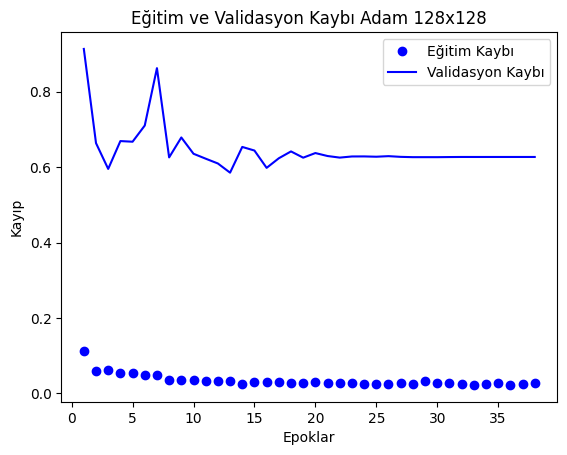

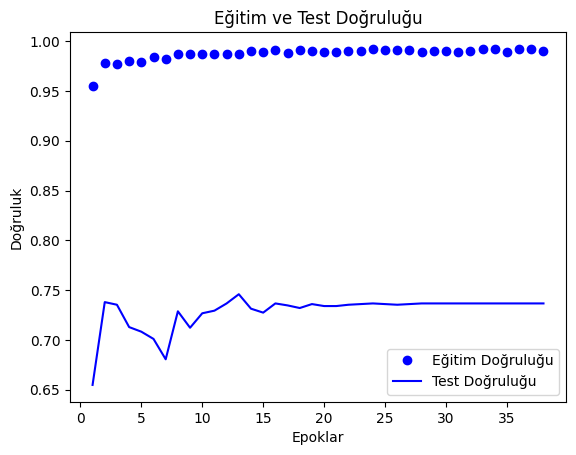

In [ ]:
import matplotlib.pyplot as plt

#Her epok sonunda eğitim kaybı (loss) ve doğruluğu (accuracy) ile validasyon kaybı ve doğruluğunu kaydedip ve eğriyi çizdiriyoruz...
# Eğitim geçmişini kaydediyoruz...
loss = history_mobilenet.history['loss']
accuracy = history_mobilenet.history['accuracy']
val_loss = history_mobilenet.history['val_loss']
val_accuracy = history_mobilenet.history['val_accuracy']


epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'b', label='Validasyon Kaybı')
plt.title('Eğitim ve Validasyon Kaybı Adam 128x128')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'bo', label='Eğitim Doğruluğu')
plt.plot(epochs, val_accuracy, 'b', label='Test Doğruluğu')
plt.title('Eğitim ve Test Doğruluğu')
plt.xlabel('Epoklar')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step


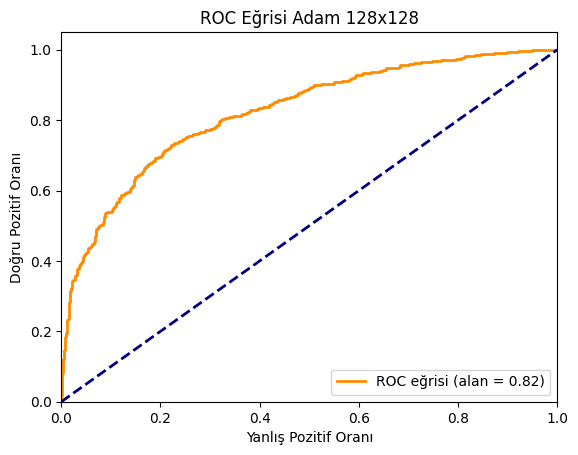

AUC: 0.8233121792434069


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# En iyi ağırlıkları yükleyin
model_mobilenet.load_weights('best_model_weights_Adam_128x128.keras')

# Fit the encoder to your original labels (if not already done)
label_encoder.fit(labels)  # 'labels' is your original label array

# Transform y_test to numerical labels
y_test_numeric = label_encoder.transform(y_test)
#*************************************************************

# Tahminleri olasılıklara dönüştürün
#ROC eğrisi veya AUC gibi metrikleri hesaplamak istiyorsak, genellikle pozitif sınıfın olasılıklarına ([:, 1] çıktısına) ihtiyaç duyacağız
#Bu durumda, y_pred_probs = model_mobilenet.predict(X_test)[:, 1] kodunu kullanmamız gerekiyor....
y_pred_probs = model_mobilenet.predict(X_test)[:, 1]

# ROC eğrisi ve AUC değerini hesaplayın
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_probs)  # Use y_test_numeric here
roc_auc = auc(fpr, tpr)


# ROC eğrisi ve AUC değerini hesaplayın
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
#roc_auc = auc(fpr, tpr)

# ROC eğrisini çizdirin
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC eğrisi (alan = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('ROC Eğrisi Adam 128x128')
plt.legend(loc="lower right")
plt.show()

# AUC değerini yazdırın
print('AUC:', roc_auc)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Confusion Matrix:
 [[600 134]
 [251 530]]


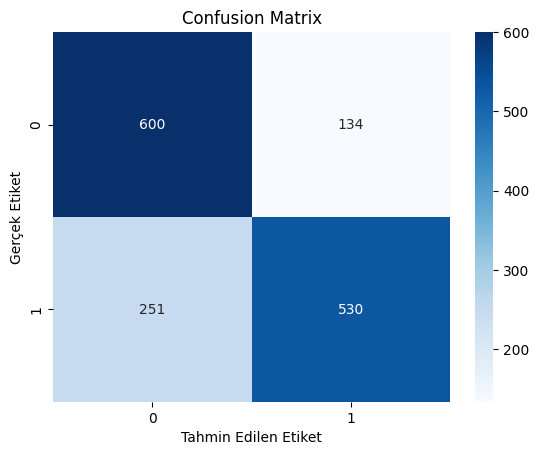

Accuracy: 0.7458745874587459
Precision: 0.7981927710843374
Recall: 0.678617157490397
Specificity: 0.8174386920980926
F1-score: 0.7335640138408305


In [ ]:
# Tahminleri sınıflara dönüştürün
y_pred = np.argmax(model_mobilenet.predict(X_test), axis=1)

# Use LabelEncoder to transform y_test to numerical labels before calculating the confusion matrix
y_test_numeric = label_encoder.transform(y_test)

# Confusion Matrix'i hesaplayın ve yazdırın
cm = confusion_matrix(y_test_numeric, y_pred)  # Use y_test_numeric here
print('Confusion Matrix:\n', cm)

# Confusion matrix'i çizdiriyoruz..
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.show()

# Accuracy, Precision, Recall, Specificity ve F1-score'u hesaplayın ve yazdırın
accuracy = accuracy_score(y_test_numeric, y_pred)  # Use y_test_numeric here
precision = precision_score(y_test_numeric, y_pred)  # Use y_test_numeric here
recall = recall_score(y_test_numeric, y_pred)  # Use y_test_numeric here
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # TN / (TN + FP)
f1 = f1_score(y_test_numeric, y_pred)  # Use y_test_numeric here

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('Specificity:', specificity)
print('F1-score:', f1)